In [128]:
import json
import os
import subprocess
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [391]:
def reformat_newick(cov, gene):
    if cov=='229e':
        lineages = ['']
    else:
        lineages = ['A','B']
    
    new_lines = []
    with open('../'+str(cov)+'/results/tree_'+str(cov)+'_'+gene+'.nwk', 'r') as input_newick:
        for line in input_newick.readlines():
            new_lines.append(line.replace('/','-').replace(str(cov), str(cov).upper()))
    for lineage in lineages:
        pact_analysis_path = '../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+str(gene)
        if path.exists(pact_analysis_path):
            with open(pact_analysis_path+'/in.trees', 'w') as output_newick:
                output_newick.writelines(new_lines)
        else:
            os.makedirs(pact_analysis_path)
            with open(pact_analysis_path+'/in.trees', 'w') as output_newick:
                output_newick.writelines(new_lines)

In [392]:
def find_lineages(cov, gene):
    
    if cov=='229e':
        lineage = ''
        lineage_tips = False
        write_param_file(cov, lineage, gene, lineage_tips)
        
    else:
        lineages = ['A','B']
    
        if cov == 'hku1':
            clade_file = '../'+str(cov)+'/results/clades_full.json'
        else:
            if gene =='spike' or gene == 's1' or gene == 's2':
                clade_file = '../'+str(cov)+'/results/clades_spike.json'
            else:
                clade_file = '../'+str(cov)+'/results/clades_full.json'    

        for lineage in lineages:
            lineage_tips = []
            with open(clade_file, "r") as clade_handle:
                clades = json.load(clade_handle)
                for node, v in clades['nodes'].items():
                    if 'NODE' not in node:
                        if v['clade_membership'] == lineage:
                            lineage_tips.append(node)

            write_param_file(cov, lineage, gene, lineage_tips)

In [414]:
def write_param_file(cov, lineage, gene, lineage_tips):
    
    min_years = {'oc43A': 1990, 'oc43B': 1987, '229e': 1989, 'hku1A': 2005, 'hku1B': 2005, 'nl63A': 1983, 'nl63B': 2001}
    max_years = {'oc43A': 2019, 'oc43B': 2019, '229e': 2019, 'hku1A': 2016, 'hku1B': 2017, 'nl63A': 2019, 'nl63B': 2018}
    
    with open('../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+gene+'/in.param', 'w') as param_file:
        param_file.write(f'push times back {min_years[str(cov)+str(lineage)]} {max_years[str(cov)+str(lineage)]}\n')
        if lineage_tips:
            param_file.write('prune to tips')
            for x in lineage_tips:
                tip = ' ' +x.replace('/','-').replace(str(cov), str(cov).upper())
                param_file.write(tip)
            param_file.write('\n')
        param_file.write(f'print rule tree\nsummary tmrca\nsummary diversity\nskyline settings {min_years[str(cov)+str(lineage)]} {max_years[str(cov)+str(lineage)]} 0.5\nskyline tmrca\nskyline diversity')


In [394]:
def run_pact(cov, gene):
    reformat_newick(cov, gene)
    find_lineages(cov, gene)
    
    if cov=='229e':
        lineages = ['']   
    else:
        lineages = ['A','B']
    
    for lineage in lineages:
        cov_lineage_directory = f"../../../PACT/{cov}{lineage}/{cov}{lineage}_{gene}"
        subprocess.Popen("cp ../../pact .", cwd= cov_lineage_directory, 
                         shell=True, stdin = subprocess.PIPE, stdout = subprocess.PIPE)
        subprocess.Popen("./pact", cwd= cov_lineage_directory, 
                         shell=True, stdin = subprocess.PIPE, stdout = subprocess.PIPE)
        

In [415]:
covs = ['229e', 'oc43', 'nl63', 'hku1']
genes = ['spike', 's1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid']

for cov in covs:
    for gene in genes:
        run_pact(cov, gene)

In [427]:
def import_pact_results(cov, genes):
    
    if cov=='229e':
        lineages = ['']
    else:
        lineages = ['A','B']
    
    df_tmrca = pd.DataFrame()
    df_diversity = pd.DataFrame()
    
    
    for lineage in lineages:
        for gene in genes:

            df_gene = pd.read_csv('../../../PACT/'+str(cov)+str(lineage)+'/'+str(cov)+str(lineage)+'_'+gene+'/out.skylines', sep='\t')
            df_gene['gene'] = gene
            df_gene['cov'] = cov
            df_gene['lineage'] = lineage
            df_t = df_gene[df_gene['statistic']=='tmrca']
            df_d = df_gene[df_gene['statistic']=='div']
            df_tmrca = df_tmrca.append(df_t)
            df_diversity = df_diversity.append(df_d)

    return df_tmrca, df_diversity

In [419]:
def plot_pact_results(stat, cov, genes):
    
    df_tmrca, df_diversity = import_pact_results(cov, genes)
    
    sns.set(font_scale=2)
    sns.set_style("white")
    
    if stat == 'tmrca':
        g = sns.FacetGrid(df_tmrca, row = 'lineage', hue='gene', height = 6, aspect = 3)
        g = (g.map(plt.plot, 'time', 'mean', lw=6).add_legend())
    
    elif stat == 'diversity':
        g = sns.FacetGrid(df_diversity, row = 'lineage', hue='gene', height = 6, aspect = 3)
        g = (g.map(plt.plot, 'time', 'mean', lw=6).add_legend())
        
#     g.fig.subplots_adjust(top=0.8)
#     g.fig.suptitle(str(cov), fontsize=30)
    

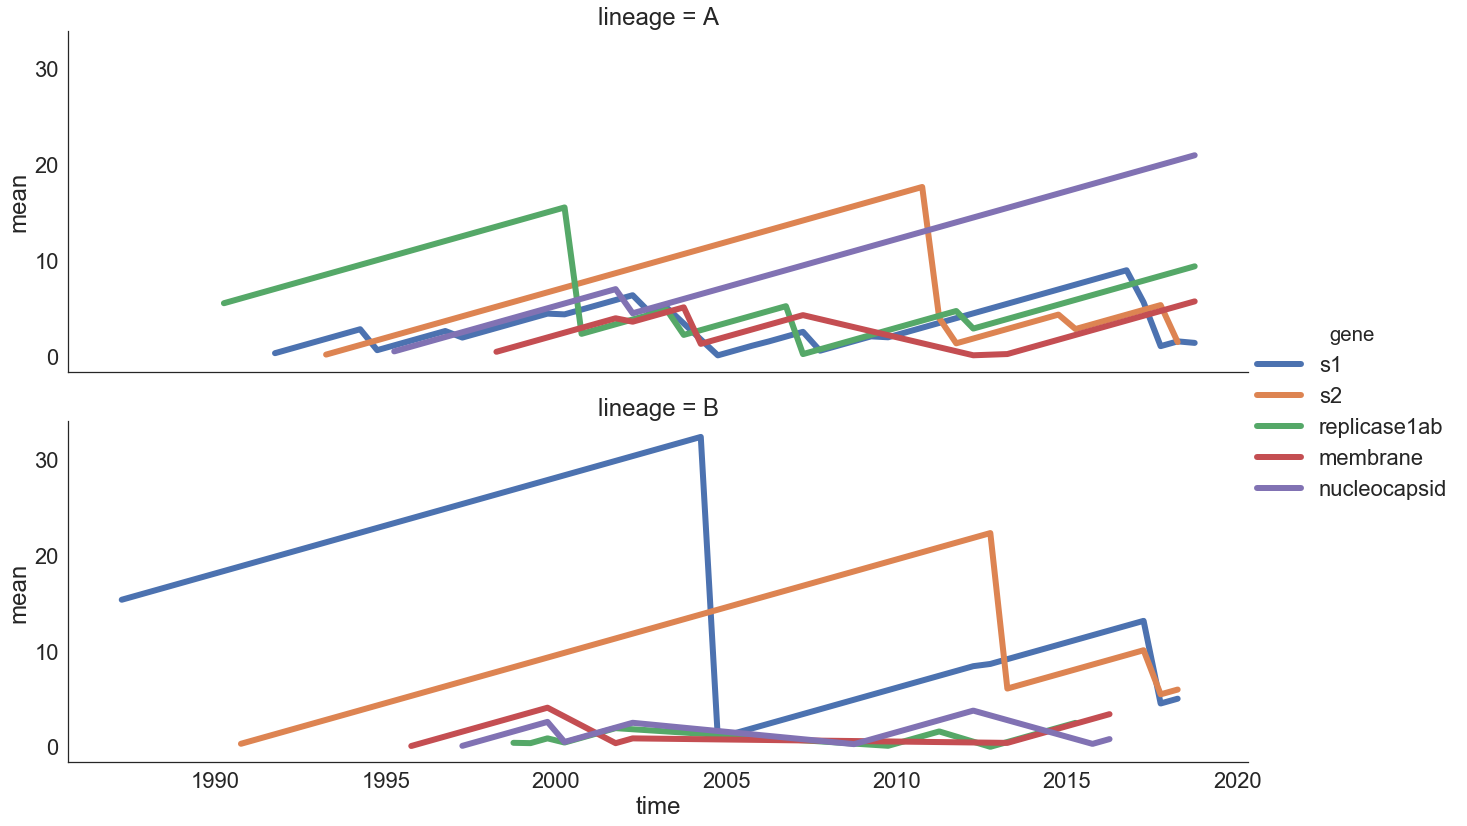

In [420]:
plot_pact_results('tmrca','oc43', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

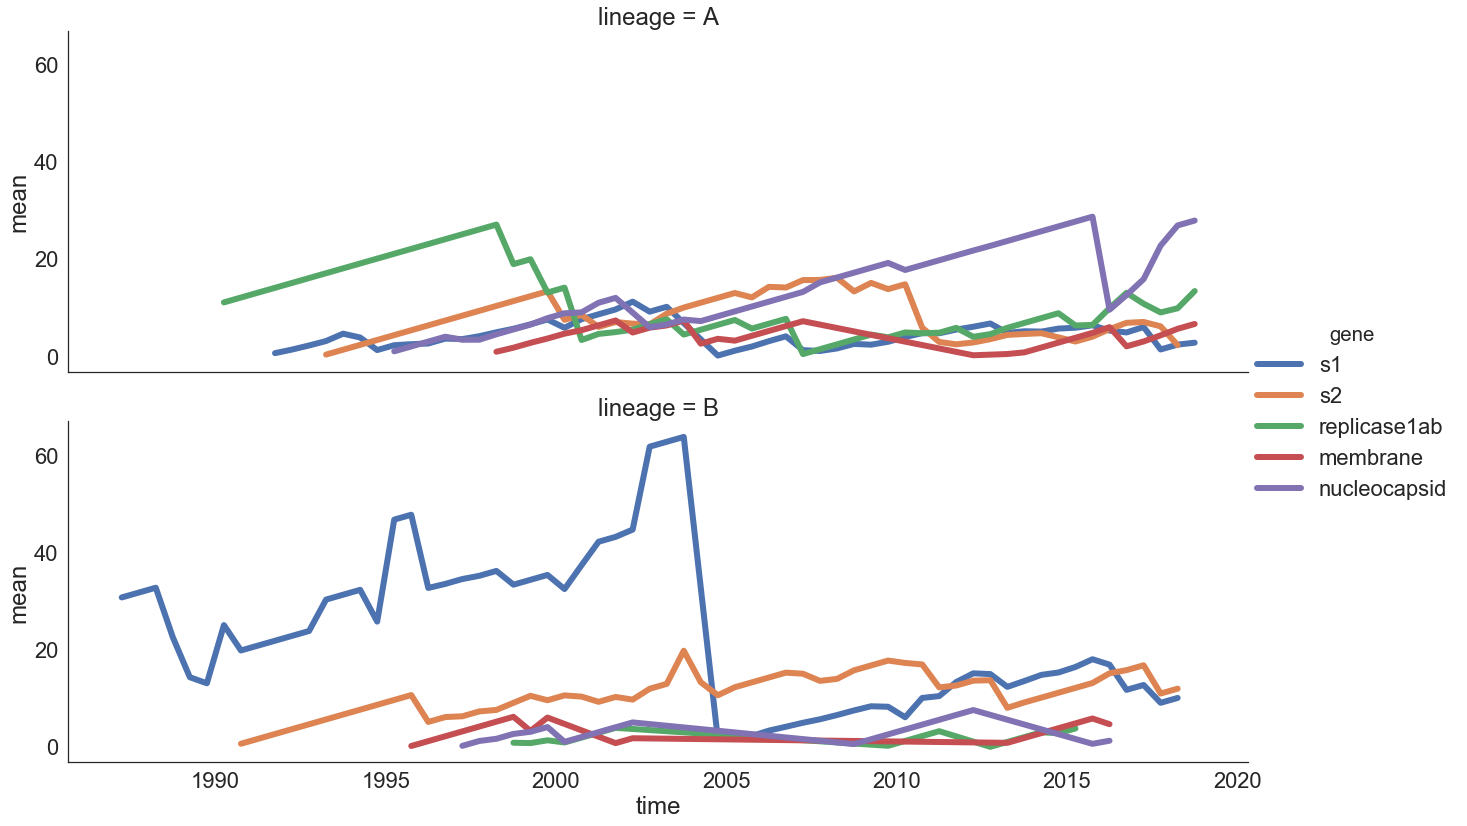

In [428]:
plot_pact_results('diversity','oc43', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

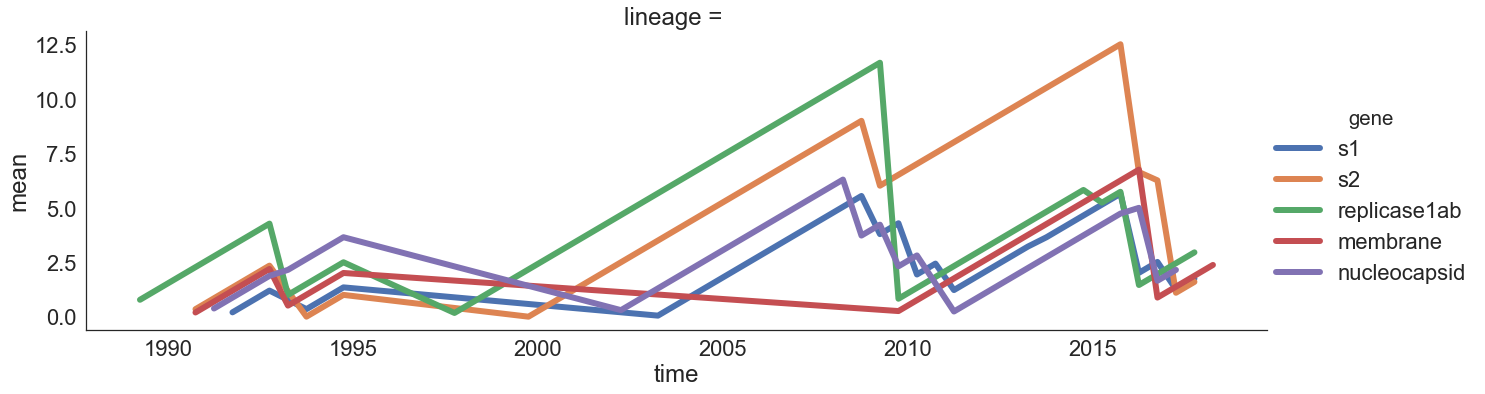

In [429]:
plot_pact_results('tmrca','229e', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

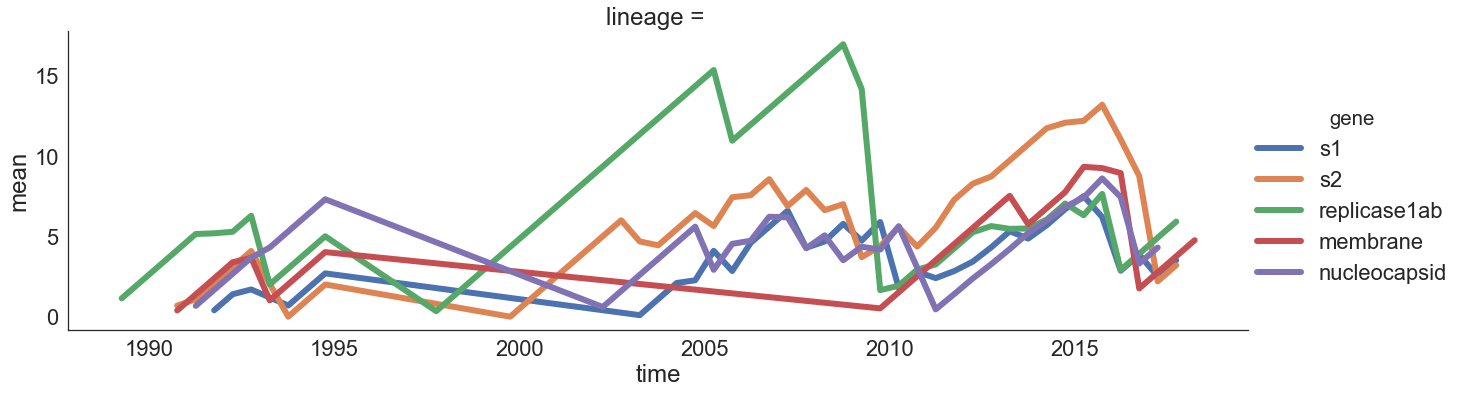

In [430]:
plot_pact_results('diversity','229e', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

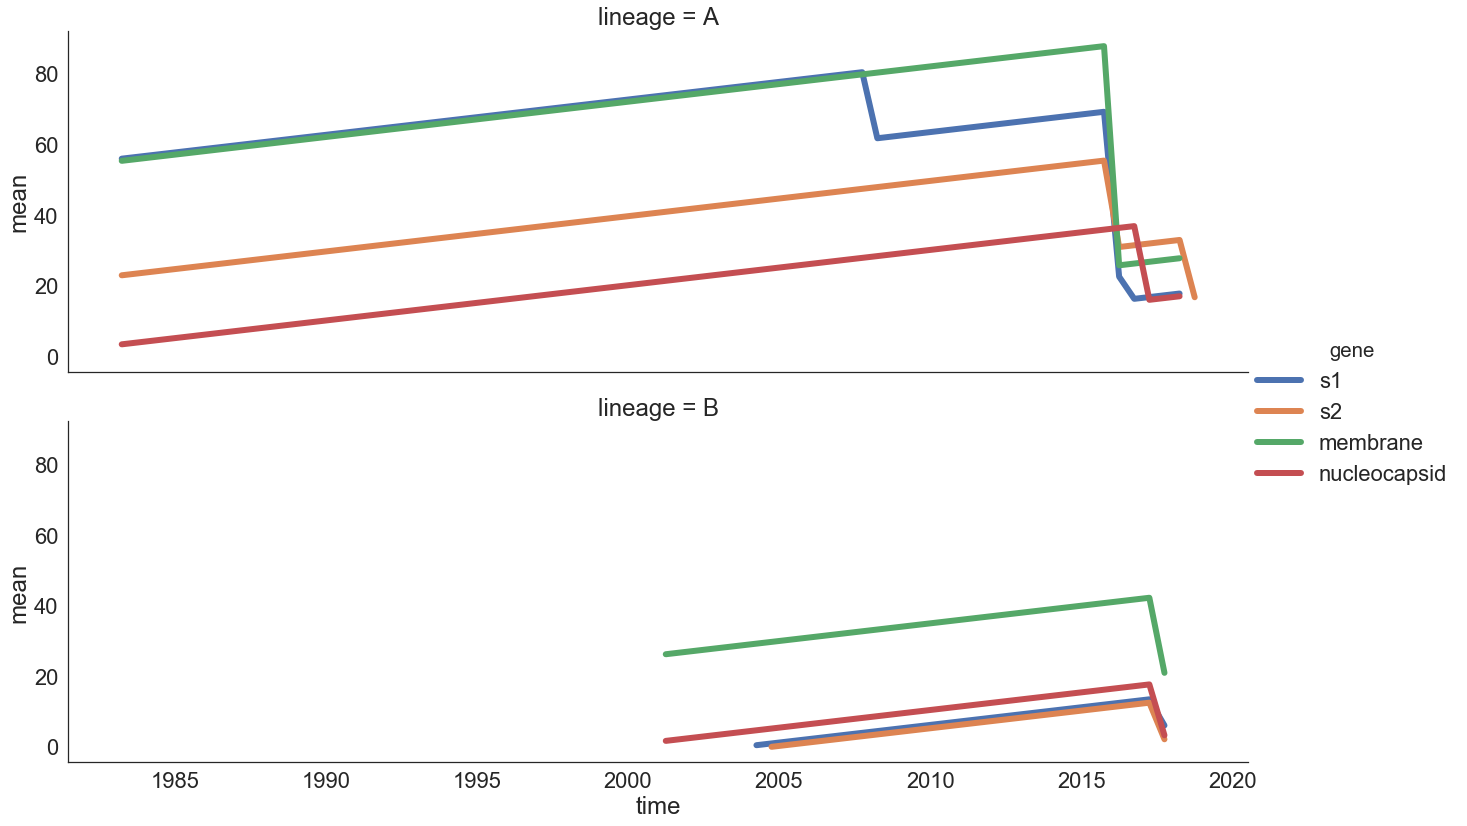

In [431]:
plot_pact_results('tmrca','nl63', ['s1', 's2', 'membrane', 'nucleocapsid'])

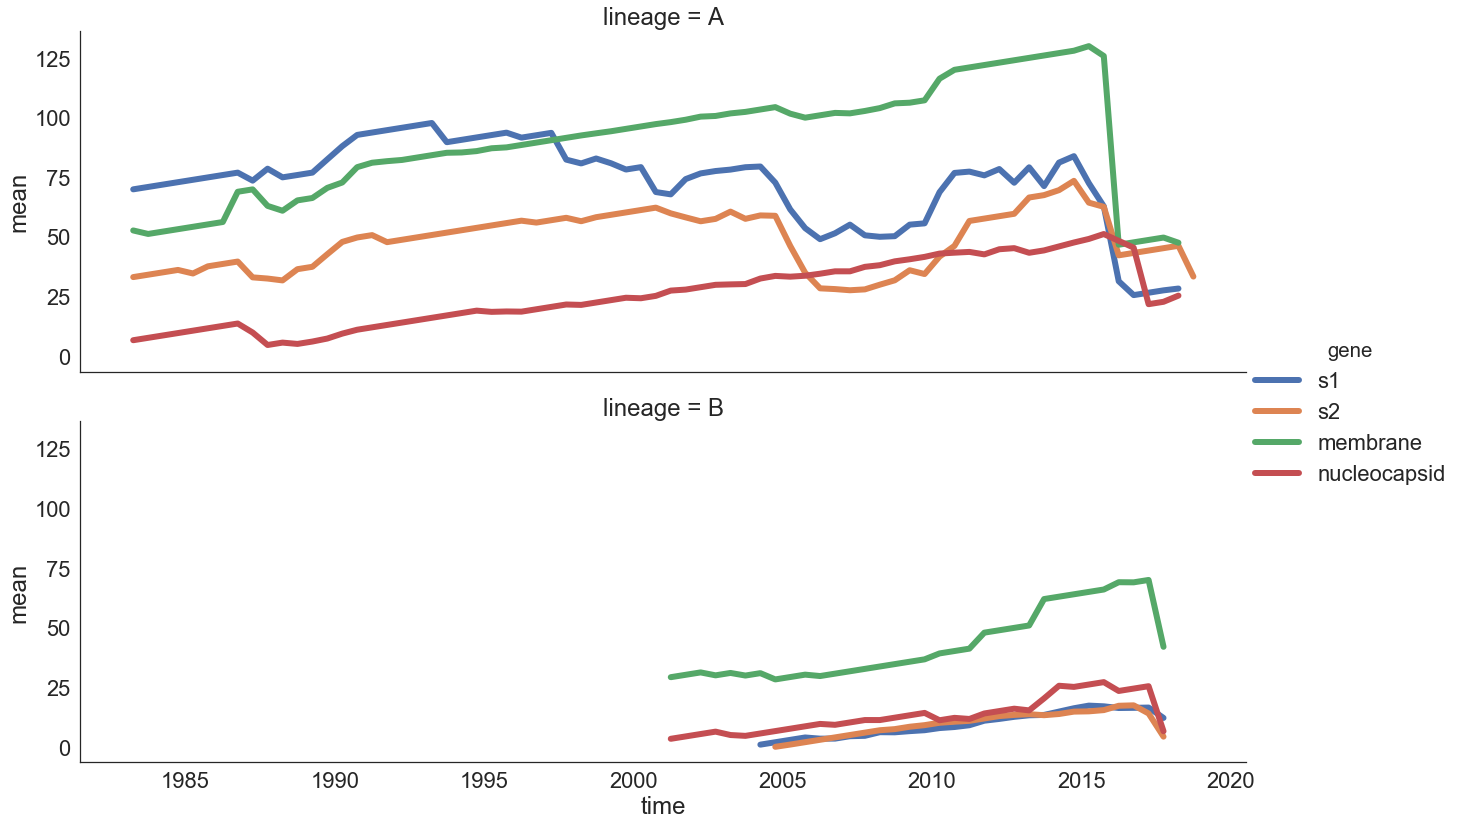

In [432]:
plot_pact_results('diversity','nl63', ['s1', 's2', 'membrane', 'nucleocapsid'])

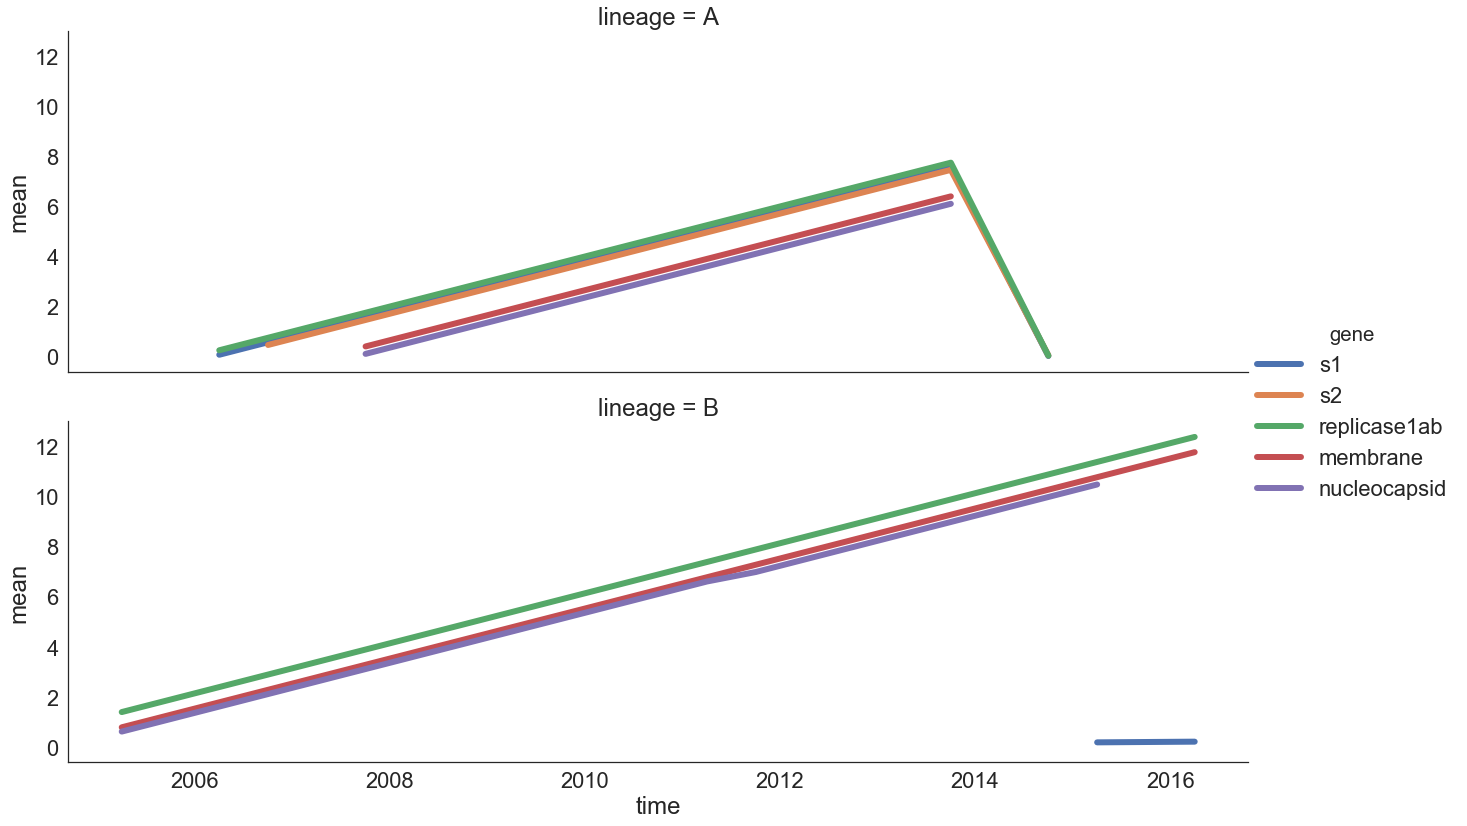

In [433]:
plot_pact_results('tmrca','hku1', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])

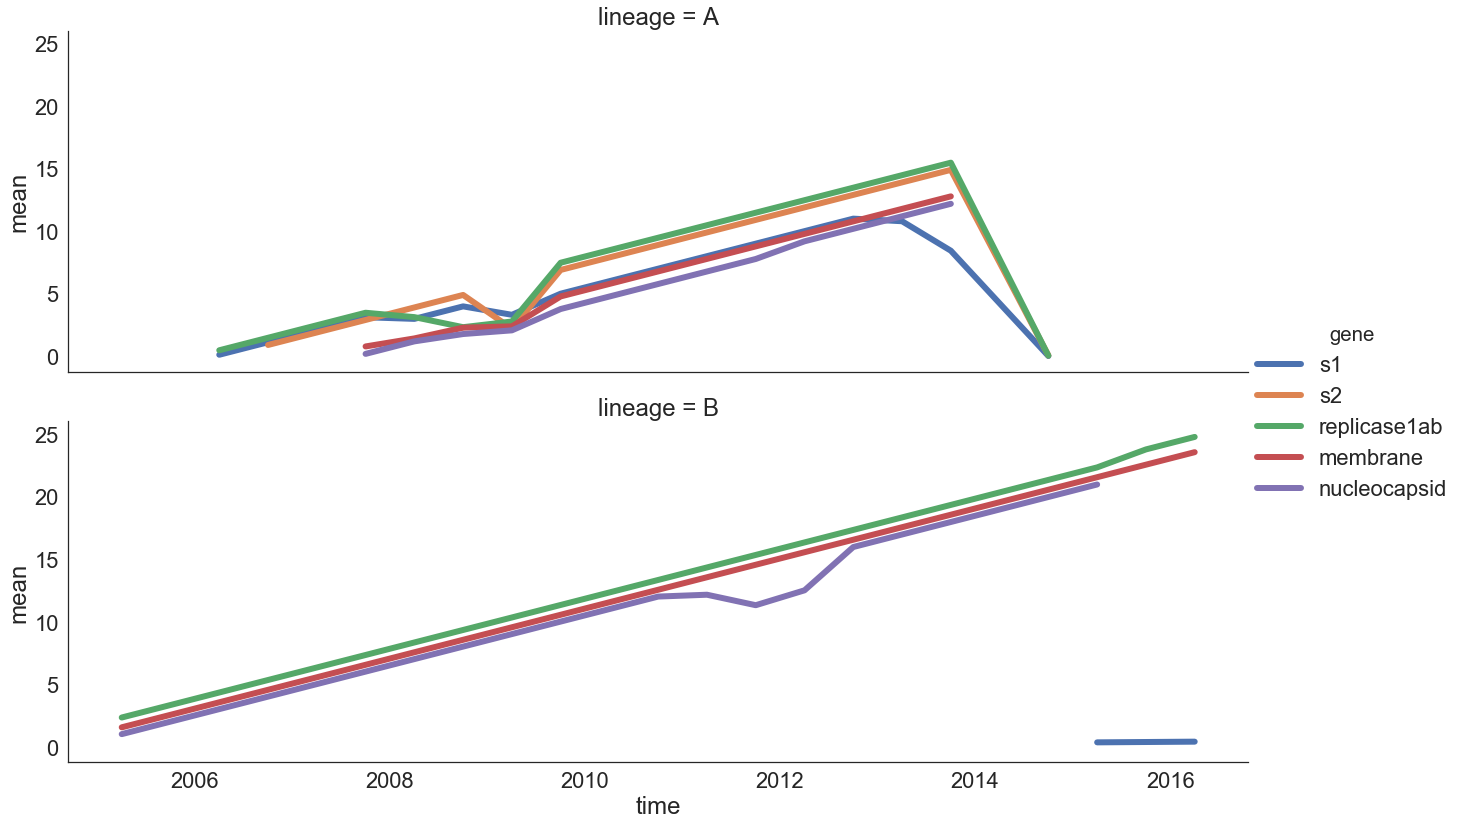

In [434]:
plot_pact_results('diversity','hku1', ['s1', 's2', 'replicase1ab', 'membrane', 'nucleocapsid'])